# Outlook #

In this colab we will study basic reinforcement learning algorithms: TD learning, q-learning and sarsa. We will also investigate two basic exploration strategies: $\epsilon$-greedy and softmax.

# Installation #

In [1]:
try:
    import my_gym
except ModuleNotFoundError as e:
    !pip install git+https://github.com/osigaud/my_gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/my_gym to /tmp/pip-req-build-yti2sjzc
  Running command git clone -q https://github.com/osigaud/my_gym /tmp/pip-req-build-yti2sjzc
     |████████████████████████████████| 1.5 MB 34.7 MB/s 
     |████████████████████████████████| 1.3 MB 54.3 MB/s 
  Created wheel for bbrl-gym: filename=bbrl_gym-0.1.0-py3-none-any.whl size=17222 sha256=e8bf67200bcd7f973c84f56588b52159b6ede651ff9c624dff4e8f892acd123b
  Stored in directory: /tmp/pip-ephem-wheel-cache-i9l156t0/wheels/0b/2c/67/5df37c12451553731420023ff73d12effcae27a38cc5053550
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=87e8c5247b59c2700928ce2609808b93476c6a18f3ce8602c89da02fb93b588e
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for mazemdp: filename=mazemdp-0.1.1-py3-none-any.whl size=14721 sha

In [2]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax, discreteProb
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from my_gym.envs.maze_mdp import MazeMDPEnv

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

# Settings
NB_EPISODES = 50
TIMEOUT = 25

Matplotlib backend: module://ipykernel.pylab.backend_inline


# Reinforcement Learning #


Reinforcement Learning is about finding the optimal policy in an MDP which is initially unknown to the agent. More precisely, the state and action spaces are known, but the agent does not know the transition and reward functions. Generally speaking, the agent has to explore the MDP to figure out which action in which state leads to which other state and reward. The model-free case is about finding this optimal policy just through very local updates, without storing any information about previous interactions with the environment. Principles of these local updates can already be found in the Temporal Difference (TD) algorithm, which iteratively computes optimal values for all state using local updates.
The most widely used model-free RL algorithms are **q-learning**, **sarsa** and **actor-critic** algorithms. Below we focus on the first two.

As for dynamic programming, we first create a maze-like MDP. Reinforcement learning is slower than dynamic programming, so we will work with smaller mazes.

In [ ]:
import gym
import my_gym


env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": 0.2})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.init_draw("The maze")

Output()

## Temporal Difference (TD) learning ##


Given a state and an action spaces as well as a policy, TD(0) computes the state value of this policy based on the following equations:
$$\delta_t = r(s_t,a_t) + \gamma V^{(t)}(s_{t+1})-V^{(t)}(s_t)$$
$$V^{(t+1)}(s_t) = V^{(t)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning rate".

The code is provided below, so that you can take inspiration later on. The important part is the computation of $\delta$, and the update of the values of $V$.

To run TD learning, a policy is needed as input. Such a policy can be retreived by using the `policy_iteration_q(mdp)` function defined in the dynamic programming notebook.

If you want to run this notebook independently, you can use instead the `random_policy` provided in `mazemdp`. This is what we do here by default, replace it if you want to run TD learning from an optimal policy.


In [ ]:
from mazemdp import random_policy

**Question:** In the code of the *temporal_difference(...)* function below, fill the missing parts with # some code = ... 

In [ ]:
def temporal_difference(
    mdp: MazeMDPEnv,
    policy: np.ndarray,
    nb_episodes: int = 50,
    alpha: float = 0.2,
    timeout: int = 25,
    render: bool = True,
) -> np.ndarray:
    # alpha: learning rate
    # timeout: timeout of an episode (maximum number of timesteps)
    v = np.zeros(mdp.nb_states)  # initial state value v
    mdp.timeout = timeout

    if render:
        mdp.init_draw("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state is drawn according to the P0
        #                                 distribution)
        s = mdp.reset(uniform=True)
        done = False
        while not done:  # update episode at each timestep
            # Show agent
            if render:
                mdp.draw_v_pi(v, policy)

            # Step forward following the MDP: x=current state,
            #                                 pol[i]=agent's action according to policy pol,
            #                                 r=reward gained after taking action pol[i],
            #                                 done=tells whether the episode ended,
            #                                 and info gives some info about the process
            y, r, done, _ = mdp.step(egreedy_loc(policy[s], mdp.action_space.size, epsilon=0.2))

            # À compléter...
            delta = r + mdp.gamma * v[y] - v[s]
            v[s] += alpha * delta

            # Update agent's position (state)
            s = y

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(v, policy, title="Temporal Differences")
    return v

Once this is done, you can run it.

In [ ]:
policy = random_policy(env)
# v = temporal_difference(env, policy, nb_episodes=NB_EPISODES, timeout=TIMEOUT)
v = temporal_difference(env, policy, nb_episodes=10, timeout=TIMEOUT)

Output()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
show_videos("videos/", "Temporal")

Converting videos/Temporaldifferences.avi


Unless you were lucky, the generated value function is boring: if the policy does not reach the final state, all values are 0. To avoid this, you can copy-paste a dynamic programming function from the previous notebook, use it to get an optimal policy, and use this policy for TD learning. You should get a much more interesting value function.

In [ ]:
# Your code to obtain an optimal policy here

def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states, dtype=int)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        if x not in mdp.terminal_states:
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy

def value_iteration_v(mdp: MazeMDPEnv) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    mdp.set_title("Value iteration V")
    mdp.set_render_func(mdp.draw_v, lambda draw: draw(v))

    while not stop:
        v_old = v.copy()
        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x not in mdp.terminal_states:
                v_temp = []
                for u in mdp.action_space.actions:
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))
    return v, v_list

v, _ = value_iteration_v(env)
policy = get_policy_from_v(env, v)
temporal_difference(env, policy, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

array([5.61968303e-03, 7.38718466e-02, 1.52433392e-01, 2.68167697e-01,
       4.77963496e-01, 1.96390993e-02, 2.83189458e-01, 6.13288719e-01,
       8.72110811e-05, 3.78480547e-04, 2.76739145e-01, 7.17946117e-01,
       7.20523109e-06, 9.32898339e-02, 4.50662566e-01, 8.52515919e-01,
       9.18921322e-10, 1.54125393e-01, 6.92393596e-01, 9.99985728e-01,
       0.00000000e+00])

## Q-learning ##


The **q-learning** algorithm accounts for an agent exploring an MDP and updating at each step a model of the state action-value function stored into a Q-table. It is updated as follows:

$$\delta_t = r(s_t,a_t) + \gamma \max_{a \in A} Q^{(t)}(s_{t+1},a)-Q^{(t)}(s_t,a_t)$$

$$Q^{(t+1)}(s_t,a_t) = Q^{(t)}(s_t,a_t) + \alpha \delta_t.$$


To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the dynamic programming notebook. Import it below.

In [ ]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

**Question:**  Fill the code of the `q_learning(...)` function below.

In [ ]:
def q_learning_base(
    mdp: MazeMDPEnv,
    param: float,
    action_choice_func,   # epsilon-greedy / softmax...
    nb_episodes:int,
    timeout:int,
    alpha:float,
    render:bool,
    render_name:str
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw(render_name)

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)
        done = False
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw an action using the chosen action choice function
            a = action_choice_func(q, s, param)

            # Perform a step of the MDP
            y, r, done, _ = mdp.step(a)

            # Update q table
            delta = r + mdp.gamma * np.max(q[y]) - q[s,a]
            q[s,a] += alpha * delta

            # Update the agent position
            s = y
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title=render_name)
    return q, q_list


# --------------------------- Q-Learning epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate

def q_learning_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    return q_learning_base(
        mdp=mdp, param=epsilon, nb_episodes=nb_episodes,
        action_choice_func=egreedy,
        timeout=timeout, alpha=alpha, render=render,
        render_name="Q-learning e-greedy",
    )

And run it.

In [ ]:
epsilon = 0.02
q, q_list = q_learning_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
show_videos("videos/", "Q-learning")

Converting videos/Q-learninge-greedy.avi


### Learning dynamics


By watching carefully the values while the agent is learning, you can see that the agent favors certains paths over others which have a strictly equivalent value. This can be explained easily: as the agent chooses a path for the first time, it updates the values along that path, these values get higher than the surrounding values, and the agent chooses the same path again and again, increasing the phenomenon. Only steps of random exploration can counterbalance this effect, but they do so extremely slowly.

### Exploration ###


In the `q_learning(...)` function above, action selection is based on a `softmax` policy. Instead, it could have relied on *$\epsilon$-greedy*.


**Question:** In the function below, you have to replace the call to the previous *$\epsilon$-greedy* policy with a `softmax` policy. The `softmax(...)` and `egreedy(...)` functions are available in `mazemdp.toolbox`.

In [ ]:
# --------------------------- Q-Learning softmax version ----------------------------#

# Given a temperature "tau", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate

def softmax_chooser(q, x, tau) -> int:
    p = softmax(q, x, tau)  # softmax distribution over action space
    cumul = np.cumsum(p)
    for i in range(p.shape[0]):
        if cumul[i] >= np.random.random():
            return i;

def q_learning_soft(
    mdp: MazeMDPEnv,
    tau: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    return q_learning_base(
        mdp=mdp, param=tau, nb_episodes=nb_episodes,
        action_choice_func=softmax_chooser,
        timeout=timeout, alpha=alpha, render=render,
        render_name="Q-learning softmax",
    )

Run this new version

In [ ]:
tau = 0.02
q, q_list = q_learning_soft(env, tau, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
show_videos("videos/", "Q-learningsoftmax")

Converting videos/Q-learningsoftmax.avi


## Sarsa ##


The **sarsa** algorithm is very similar to **q-learning**. At first glance, the only difference is in the update rule. However, to perform the update in **sarsa**, one needs to know the action the agent will take when it will be at the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored for being played at the next time step.


**Question:** Fill the code below

In [ ]:
def sarsa_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa e-greddy")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)
        
        # Init first action
        a = egreedy(q, s, epsilon)
        
        done = False
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw the next action using the chosen action choice function
            a_next = egreedy(q, s, epsilon)

            # Perform a step of the MDP
            y, r, done, _ = mdp.step(a)

            # Update q table
            delta = r + mdp.gamma * q[y,a_next] - q[s,a]
            q[s,a] += alpha * delta

            # Update the agent position and make next action current
            s = y
            a = a_next

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Sarsa e-greddy")
    return q, q_list

And run it.

In [ ]:
epsilon = 0.02
q, q_list = sarsa_eps(env, epsilon, nb_episodes=NB_EPISODES, timeout=TIMEOUT)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
show_videos("videos/", "Sarsae")

Converting videos/Sarsae-greddy.avi


As for **q-learning** above, copy-paste the resulting code to get a *sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [ ]:
# --------------------------- Sarsa, softmax version -------------------------------#

# Given a temperature "tau", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate
def sarsa_soft(
    mdp: MazeMDPEnv,
    tau: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Sarsa softmax")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        s = mdp.reset(uniform=True)
        
        # Init first action
        a = softmax_chooser(q, s, tau)
        
        done = False
        while not done:
            if render:
                # Show the agent in the maze
                mdp.draw_v_pi(q, q.argmax(axis=1))

            # Draw the next action using the chosen action choice function
            a_next = softmax_chooser(q, s, tau)

            # Perform a step of the MDP
            y, r, done, _ = mdp.step(a)

            # Update q table
            delta = r + mdp.gamma * q[y,a_next] - q[s,a]
            q[s,a] += alpha * delta

            # Update the agent position and make next action current
            s = y
            a = a_next

        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Sarsa softmax")
    return q, q_list

And run it.

In [ ]:
tau = 6
q, q_list = sarsa_soft(env, tau, nb_episodes=NB_EPISODES)

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
show_videos("videos/", "Sarsasoftmax")

Converting videos/Sarsasoftmax.avi


## Study part

### Impact of `epsilon` and `tau` on q-learning and sarsa

Compare the number of steps needed by **q-learning** and **sarsa** to converge on a given MDP using the *softmax* and *$\epsilon$-greedy* exploration strategies. To figure out, you can use the provided `plot_ql_sarsa(m, epsilon, tau, nb_episodes, timeout, alpha, render)` function below with various values for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\tau$ (e.g. 0.1, 5, 10) and comment the obtained curves. Other visualizations are welcome.

Note that instead of the temperature `tau`, computational neuroscience researchers, who generally prefer softmax exploration, use a parameter `beta` which behaves as an inverse of the temperature. That way, the three hyper-parameters of basic tabular RL algorithms are `alpha`, `beta`, and `gamma`.

In [ ]:

# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#

def plot_ql_sarsa(m, epsilon, tau, nb_episodes, timeout, alpha, render):
    q, q_list1 = q_learning_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list2 = q_learning_soft(m, tau, nb_episodes, timeout, alpha, render)
    q, q_list3 = sarsa_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list4 = sarsa_soft(m, tau, nb_episodes, timeout, alpha, render)

    plt.figure()
    plt.plot(range(len(q_list1)), q_list1, label='q-learning epsilon')
    plt.plot(range(len(q_list2)), q_list2, label='q-learning tau')
    plt.plot(range(len(q_list3)), q_list3, label='sarsa epsilon')
    plt.plot(range(len(q_list4)), q_list4, label='sarsa tau')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of Q values')
    plt.legend(loc='lower right')
    # plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

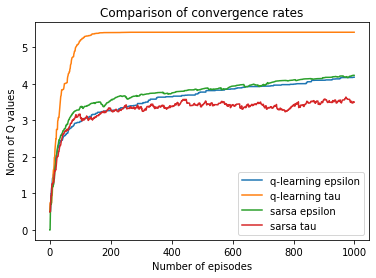

In [ ]:
# example
tau = 6
epsilon = 0.02
plot_ql_sarsa(env, epsilon, tau, 1000, 50, 0.5, False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

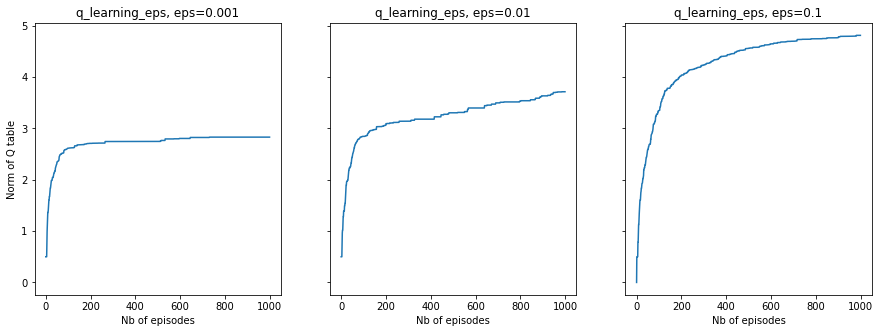

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

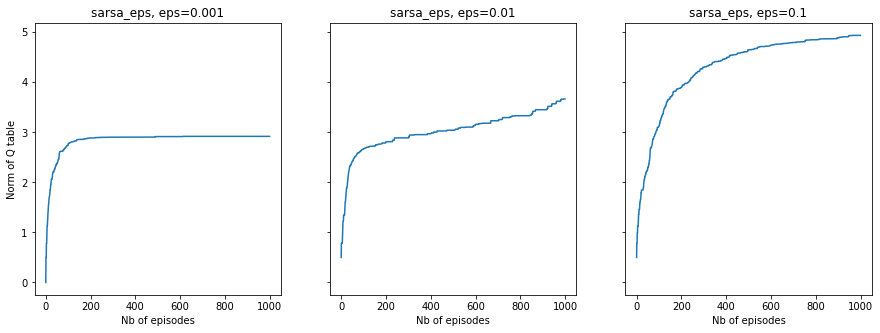

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

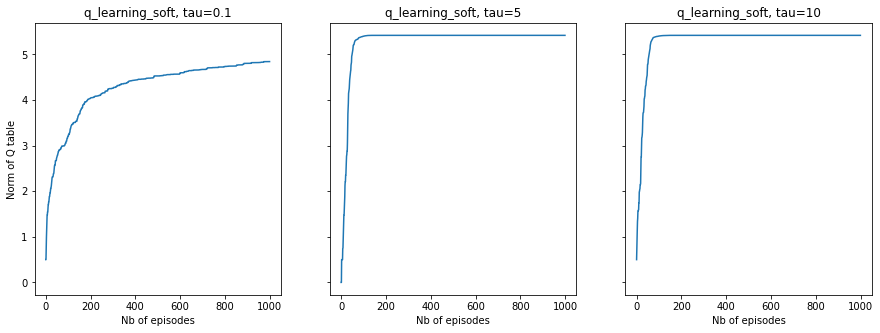

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

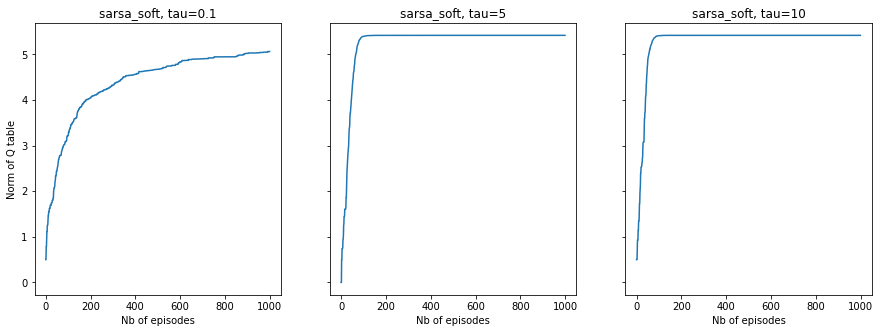

In [ ]:
from typing import List

# Comparing convergence of same method but different parameters
def plot_one_norm_convergence(
    env: MazeMDPEnv,
    nb_eps: int,
    timeout: int,
    alpha: int,
    method,   # learning function
    params: List[float],
    ylabel: str,
    param_name: str
) -> None:
  fig, ax = plt.subplots(nrows=1, ncols=len(params), sharey=True)
  fig.set_figheight(5)
  fig.set_figwidth(5 * len(params))
  for i, p in enumerate(params):
    q, q_list = q_learning_eps(env, p, nb_eps, timeout, alpha, False)
    ax[i].plot(range(len(q_list)), q_list)
    ax[i].set_title(f"{method.__name__}, {param_name}={p}")
    ax[i].set_xlabel("Nb of episodes")
  ax[0].set_ylabel(ylabel)
  plt.show()

plot_one_norm_convergence(env, 1000, 50, 0.5, q_learning_eps, [0.001, 0.01, 0.1], "Norm of Q table", "eps")
plot_one_norm_convergence(env, 1000, 50, 0.5, sarsa_eps, [0.001, 0.01, 0.1], "Norm of Q table", "eps")
plot_one_norm_convergence(env, 1000, 50, 0.5, q_learning_soft, [0.1, 5, 10], "Norm of Q table", "tau")
plot_one_norm_convergence(env, 1000, 50, 0.5, sarsa_soft, [0.1, 5, 10], "Norm of Q table", "tau")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

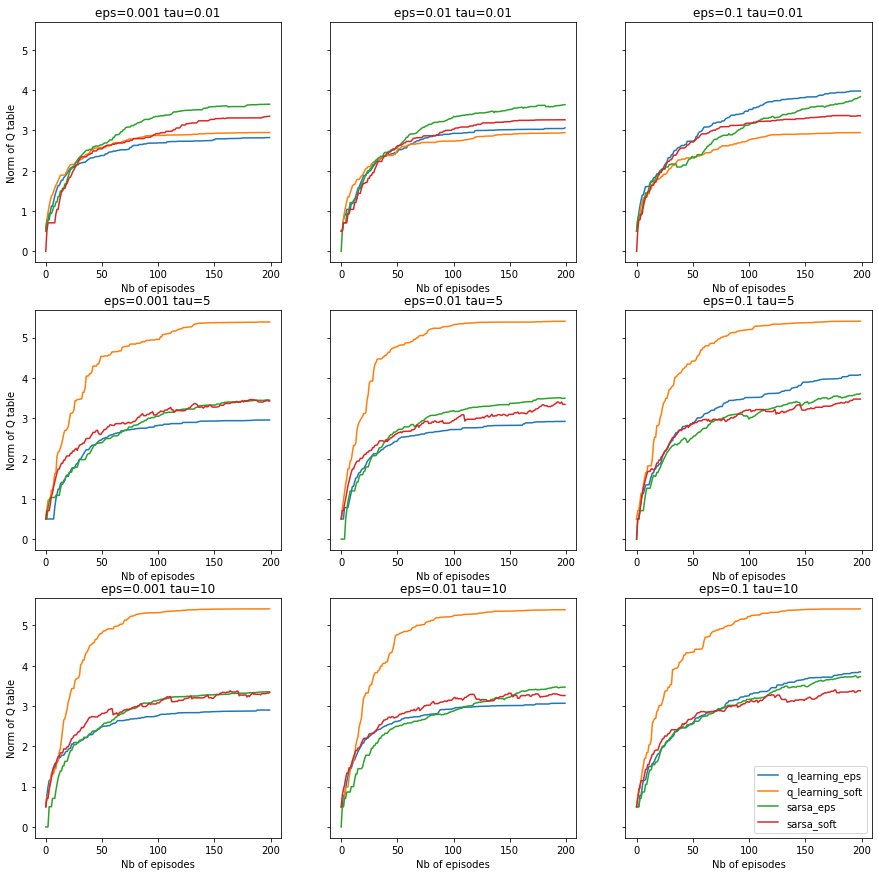

In [ ]:
# Combine the graphs vertically

NB_EPISODES = 200
TIMEOUT = 50
ALPHA = 0.5

tau = [0.01, 5, 10]
eps = [0.001, 0.01, 0.1]
methods = [q_learning_eps, q_learning_soft, sarsa_eps, sarsa_soft]

fig, ax = plt.subplots(nrows=len(tau), ncols=len(eps), sharey=True)
fig.set_figheight(5 * len(tau))
fig.set_figwidth(5 * len(eps))
for i, t in enumerate(tau):
  for j, e in enumerate(eps):
    plots = []
    for m in methods:
      p = e if m.__name__.endswith('eps') else t
      q, q_list = m(env, p, NB_EPISODES, TIMEOUT, alpha=ALPHA, render=False)
      plots.append(ax[i,j].plot(range(len(q_list)), q_list)[0])
    ax[i,j].set_title(f"eps={e} tau={t}")
    ax[i,j].set_xlabel("Nb of episodes")
  ax[i, 0].set_ylabel("Norm of Q table")
plt.legend(plots, [m.__name__ for m in methods])
plt.show()

### Effect of hyper-parameters

The other two hyper-parameters of **q-learning** and **sarsa** are $\alpha$, and $\gamma$. By varying the values of these hyper-parameters and watching the learning process and behavior of the agent, explain their impact on the algorithm. Using additional plotting functions is also welcome.